In [2]:
import os


import pprint
import random
import numpy as np
import pandas as pd

import spacy
import sys
sys.path.append("../")
from datatools.analyzer import *
# from datatools.analyzer import clean_text
from error_tools import *

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
from nltk.lm        import Vocabulary
# from nltk.lm.models import MLE
from nltk.lm.models import KneserNeyInterpolated
from nltk.util      import ngrams

In [4]:
path = "../hand_labeled/"
datalist = ['DCM', 'DIT', 'IRS']
error_types = ['Unclear intention', 'Wrong information',
 'Ignore question', 'Topic transition error', 
 'Lack of information', 'Repetition', 
 'Contradiction', 'Self-contradiction',
  'Lack of common sense', 'Semantic error',
   'Grammatical error', 'Ignore proposal', 
   'Ignore offer', 'Lack of sociality', 
   'Uninterpretable', 'Ignore greeting', 
   'No-Err']


In [4]:
convs = read_conv(path, datalist)

In [5]:
usr_utt = []
for conv in convs:
    for i, ut in enumerate(conv):
        if not ut.is_system():
            usr_utt.append(clean_text(ut.utt))
            

In [6]:
from tqdm import tqdm
def extract_utt_nucc(path):
    files = os.listdir(path)
    nucc_convs = []
    for filename in tqdm(files):
        if ".json" not in filename:
            continue
        # name = filename.split(".")[0]
        with open(path+filename, "r") as f:
            data  = json.load(f)
            for conv in data["turns"]:
                utt = conv["utterance"]
                if len(nlp(utt)) < 2:
                    # print(utt)
                    continue
                nucc_convs.append(utt)
    return nucc_convs

In [7]:
# nuccデータ
nucc_path = "../../corpus/nucc/conv2/"
nucc_convs = extract_utt_nucc(nucc_path)

100%|██████████| 91/91 [08:15<00:00,  5.44s/it]


In [8]:
usr_utt += nucc_convs

In [9]:
filled_normal = fill_SYMBOL( sentence2normalize_nv(usr_utt) )

In [10]:
def create_language_model(sentences, N):
    vocab = Vocabulary([word for sent in sentences for word in sent])
    text_ngrams = [ngrams(sent, N) for sent in sentences]
    lm = KneserNeyInterpolated(order=N, vocabulary=vocab)
    lm.fit(text_ngrams)
    return lm

In [11]:
n=3
lm = create_language_model(filled_normal, N=n)

In [12]:
context = ("そう", 'です')

In [13]:
len(usr_utt)

45385

In [14]:
print(context, '->')

('そう', 'です') ->


In [15]:
prob_list = []
for word in lm.context_counts(lm.vocab.lookup(context)): # 文脈に続く単語一覧の取得
    prob_list.append((word, lm.score(word, context))) # 単語のその出現する確率を格納

prob_list.sort(key=lambda x: x[1], reverse=True) # 出現確率順にソート
for word, prob in prob_list:
    print('\t{:s}: {:f}'.format(word, prob))

	ね: 0.401385
	か: 0.269078
	よ: 0.159847
	。: 0.066001
	かー: 0.027539
	、: 0.024462
	ねー: 0.021385
	ねえ: 0.013693
	けど: 0.002924
	EOS: 0.001385
	が: 0.001385
	そう: 0.001385
	もん: 0.001385
	って: 0.001385
	な: 0.001385
	よー: 0.001385
	かあ: 0.001385


In [5]:
import math
import pprint
def sentence2score(sentence, l, N):
    filled = fill_SYMBOL( sentence2normalize_nv(sentence) )
    filled_pos = fill_SYMBOL( sentence2pos(sentence) )
    print(filled)
    print(filled_pos)
    ngram_text = []
    ngram_pos = []
    for L, P in zip(filled,filled_pos):
        for i in range(len(L)-N+1):
            # print(L[i:i+N])
            ngram_text.append(L[i:i+N])
            ngram_pos.append(P[i:i+N])
    # pprint.pprint(ngram_text)
    all_score = 0
    for ngram, pgram in zip(ngram_text, ngram_pos):
        context = (ngram[:-1])
        context_pos = pgram[:-1]
        # print(context)
        # for word in lm.context_counts(lm.vocab.lookup(context)): # 文脈に続く単語一覧の取得
            
        score = lm.score(ngram[-1], context) + 1e-4
        
        log_score = math.log2(score)
        print("context : {0}|{1} ->".format(context_pos, context), log_score)
        all_score += log_score
    # print(all_score/len(ngram_text))
    return all_score/len(ngram_text)
    

In [12]:

n=3
sentence = "最近とても暑いですから。"
sentence = "ご存知ですいます"
sentence2score(sentence, lm, N=n)

[['FOS', 'FOS', '名詞-普通名詞-一般', 'です', '動詞-非自立可能', 'ます', 'EOS', 'EOS']]
[['FOS', 'FOS', '名詞-普通名詞-一般', '助動詞', '動詞-非自立可能', '助動詞', 'EOS', 'EOS']]
context : ['FOS', 'FOS']|['FOS', 'FOS'] -> -2.628602211148196
context : ['FOS', '名詞-普通名詞-一般']|['FOS', '名詞-普通名詞-一般'] -> -7.129247118454044
context : ['名詞-普通名詞-一般', '助動詞']|['名詞-普通名詞-一般', 'です'] -> -13.269032148053485
context : ['助動詞', '動詞-非自立可能']|['です', '動詞-非自立可能'] -> -11.23370263865808
context : ['動詞-非自立可能', '助動詞']|['動詞-非自立可能', 'ます'] -> -4.790922775214437
context : ['助動詞', 'EOS']|['ます', 'EOS'] -> -0.003558166546429428


-6.5091775096791125

In [47]:
filled = fill_SYMBOL( sentence2normalize_nv(sentence) )

In [48]:
ngram_text = []
for L in filled:
    for i in range(len(L)-n+1):
            # print(L[i:i+N])
        ngram_text.append(L[i:i+n])
print(ngram_text)

[['FOS', 'FOS', '名詞-普通名詞-一般'], ['FOS', '名詞-普通名詞-一般', 'です'], ['名詞-普通名詞-一般', 'です', '動詞-非自立可能'], ['です', '動詞-非自立可能', 'ます'], ['動詞-非自立可能', 'ます', 'EOS'], ['ます', 'EOS', 'EOS']]


In [49]:
lm.perplexity(ngram_text)

197.59363815785343

In [6]:
from datatools.maneger import DataManager

In [9]:
modelM = DataManager("../models/utterance/")
model_name = "KLM_nucc.pickle"

In [52]:

modelM.save_data(model_name, lm)

success save : ../models/utterance/KLM_nucc.pickle


In [10]:
lm = modelM.load_data(model_name)

success load : ../models/utterance/KLM_nucc.pickle


In [54]:
errors = ['Grammatical error', "Uninterpretable"]

y = []
n=3
y_pred = []
for conv in convs:
    for ut in conv:
        if not ut.is_system():
            continue
        # エラーなら1
        if ut.is_error_included(errors):
            # print(ut)
            y.append(1)
        else:
            y.append(0)
        #LM 判定
        # エラーなら1
        if sentence2score(ut.utt, lm, N=n) < -5.6:
            y_pred.append(1)
        else:
            y_pred.append(0)

        

[['FOS', 'FOS', 'こんばんは', '！', 'EOS', 'EOS'], ['FOS', 'FOS', '名詞-普通名詞-一般', 'へ', '動詞-非自立可能', 'たい', 'ね', '。', 'EOS', 'EOS']]
[['FOS', 'FOS', '感動詞-一般', '補助記号-句点', 'EOS', 'EOS'], ['FOS', 'FOS', '名詞-普通名詞-一般', '助詞-格助詞', '動詞-非自立可能', '助動詞', '助詞-終助詞', '補助記号-句点', 'EOS', 'EOS']]
context : ['FOS', 'FOS'] -> -12.681300239359445
context : ['FOS', '感動詞-一般'] -> -12.981515615061278
context : ['感動詞-一般', '補助記号-句点'] -> -11.23370263865808
context : ['補助記号-句点', 'EOS'] -> -0.0019472472487923405
context : ['FOS', 'FOS'] -> -2.628602211148196
context : ['FOS', '名詞-普通名詞-一般'] -> -10.550970432802457
context : ['名詞-普通名詞-一般', '助詞-格助詞'] -> -1.0865334875134631
context : ['助詞-格助詞', '動詞-非自立可能'] -> -4.6472660897611755
context : ['動詞-非自立可能', '助動詞'] -> -4.703451371931372
context : ['助動詞', '助詞-終助詞'] -> -0.2502890490721515
context : ['助詞-終助詞', '補助記号-句点'] -> -0.007723035568827088
context : ['補助記号-句点', 'EOS'] -> 0.00014195957790803088
[['FOS', 'FOS', '名詞-普通名詞-一般', 'に', '動詞-非自立可能', 'ない', 'ん', 'です', 'ね', '？', 'EOS', 'EOS']]
[['F

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
print('confusion matrix = \n', confusion_matrix(y_true=y, y_pred=y_pred))
print('accuracy = ', accuracy_score(y_true=y, y_pred=y_pred))

print('EM:', metrics.accuracy_score(y, y_pred))
print('F-measure: ', metrics.f1_score(y, y_pred))

confusion matrix = 
 [[1742  454]
 [   3    1]]
accuracy =  0.7922727272727272
EM: 0.7922727272727272
F-measure:  0.004357298474945534


In [ ]:
for conv in convs:
    for ut in conv:
        if sentence2score(ut.utt, lm, N=3) < -5.5:
            # print(ut.utt)
            pass
        else:
            # print(ut.utt)
            pass

[['FOS', 'FOS', 'こんばんは', '！', 'EOS', 'EOS'], ['FOS', 'FOS', '名詞-普通名詞-一般', 'へ', '動詞-非自立可能', 'たい', 'ね', '。', 'EOS', 'EOS']]
[['FOS', 'FOS', 'こんばんは'],
 ['FOS', 'こんばんは', '！'],
 ['こんばんは', '！', 'EOS'],
 ['！', 'EOS', 'EOS'],
 ['FOS', 'FOS', '名詞-普通名詞-一般'],
 ['FOS', '名詞-普通名詞-一般', 'へ'],
 ['名詞-普通名詞-一般', 'へ', '動詞-非自立可能'],
 ['へ', '動詞-非自立可能', 'たい'],
 ['動詞-非自立可能', 'たい', 'ね'],
 ['たい', 'ね', '。'],
 ['ね', '。', 'EOS'],
 ['。', 'EOS', 'EOS']]
[['FOS', 'FOS', 'そう', 'です', 'ね', '。', 'EOS', 'EOS'], ['FOS', 'FOS', '名詞-普通名詞-副詞可能', 'とても', '暑い', 'です', 'から', '。', 'EOS', 'EOS']]
[['FOS', 'FOS', 'そう'],
 ['FOS', 'そう', 'です'],
 ['そう', 'です', 'ね'],
 ['です', 'ね', '。'],
 ['ね', '。', 'EOS'],
 ['。', 'EOS', 'EOS'],
 ['FOS', 'FOS', '名詞-普通名詞-副詞可能'],
 ['FOS', '名詞-普通名詞-副詞可能', 'とても'],
 ['名詞-普通名詞-副詞可能', 'とても', '暑い'],
 ['とても', '暑い', 'です'],
 ['暑い', 'です', 'から'],
 ['です', 'から', '。'],
 ['から', '。', 'EOS'],
 ['。', 'EOS', 'EOS']]
[['FOS', 'FOS', '名詞-普通名詞-一般', 'に', '動詞-非自立可能', 'ない', 'ん', 'です', 'ね', '？', 'EOS', 'EOS']]
[['FOS', 'FOS', '名詞-普通名詞-一般

KeyboardInterrupt: 

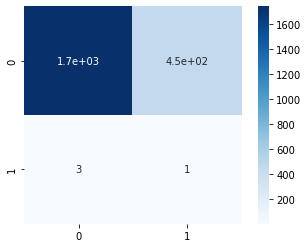

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true=y, y_pred=y_pred)
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.savefig('sklearn_confusion_matrix.png')

In [ ]:
print(lm.counts)

<NgramCounter with 3 ngram orders and 951263 ngrams>
